In [ ]:
%matplotlib inline
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.compat import lzip
from statsmodels.graphics.api import abline_plot
from statsmodels.genmod.generalized_linear_model import GLM

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Reading csv data
df = pd.read_csv('data1.csv')

Data Check

In [ ]:
# Rows containing duplicate data
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows:", duplicate_rows_df.shape)

number of duplicate rows: (378, 11)


In [ ]:
# Dropping duplicate rows
df1 = df.drop_duplicates()
df1.head(5)

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,X_OBSTAT_
0,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2,01101 0 0 0
1,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4,01101 0 0 0
2,3.26,0.569473,0,0,0.0,UTE,2,F,E,2,01101 0 0 0
3,4.14,0.317591,0,0,0.0,STNWG,2,F,D,2,01101 0 0 0
4,0.72,0.648871,0,0,0.0,HBACK,4,F,C,2,01101 0 0 0


In [ ]:
# Dropping observations with zero vehicle value
df2 = df1[df1.veh_value !=0]

Exploring Data

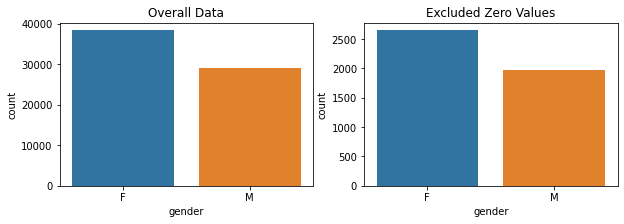

In [ ]:
#Gender
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='gender',data=df2.sort_values('gender'), ax=ax1)
title = g.set_title('Overall Data')
g = sns.countplot(x='gender',data=df2[df2['numclaims']>0].sort_values('gender'), ax=ax2)
title = g.set_title('Excluded Zero Values')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


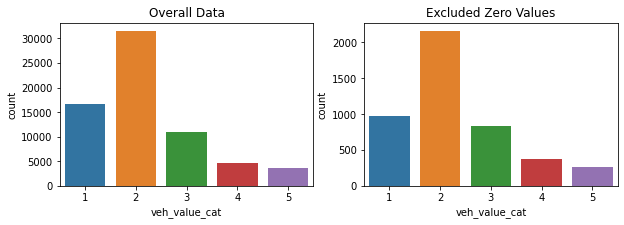

In [ ]:
# Converting vehcile value as categorical
df2['veh_value_cat'] = df2['veh_value'].apply(lambda x:1 if x<=1 else 2 if x<=2 else 3 if x<=3 else 4 if x<=4 else 5)
#Graphs
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='veh_value_cat',data=df2, ax=ax1)
title = g.set_title('Overall Data')
g = sns.countplot(x='veh_value_cat',data=df2[df2['numclaims']>0], ax=ax2)
title = g.set_title('Excluded Zero Values')

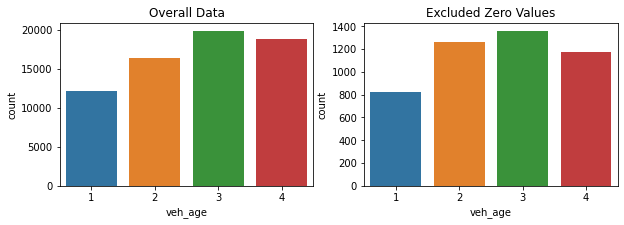

In [ ]:
# Vehicle Age
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='veh_age',data=df2,ax=ax1)
title = g.set_title('Overall Data')
g = sns.countplot(x='veh_age',data=df2[df2['numclaims']>0], ax=ax2)
title = g.set_title('Excluded Zero Values')

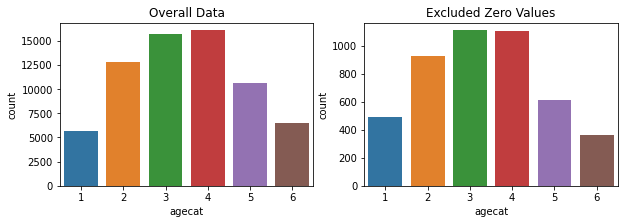

In [ ]:
# Driver Age
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='agecat',data=df2, ax=ax1)
title = g.set_title('Overall Data')
g = sns.countplot(x='agecat',data=df2[df2['numclaims']>0],ax=ax2)
title = g.set_title('Excluded Zero Values')

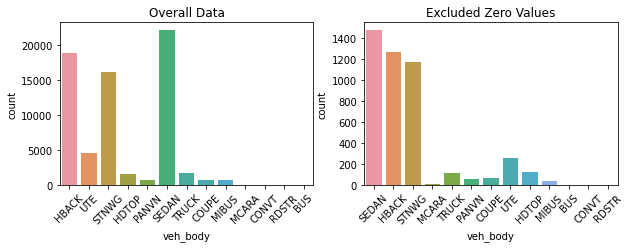

In [ ]:
# Vehicle Body Type
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='veh_body',data=df2,ax=ax1)
label = g.set_xticklabels(g.get_xticklabels(), rotation=45)
title = g.set_title('Overall Data')
g = sns.countplot(x='veh_body',data=df2[df2['numclaims']>0], ax=ax2)
label = g.set_xticklabels(g.get_xticklabels(), rotation=45)
title = g.set_title('Excluded Zero Values')

In [ ]:
#Grouping bottom categories as "others"
series = pd.value_counts(df2.veh_body)
mask = (series/series.sum() * 100).lt(1)
# To replace df['column'] use np.where I.e
df2['veh_body'] = np.where(df2['veh_body'].isin(series[mask].index),'Other',df2['veh_body'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Converting into string
df3 = df2.astype({"veh_body":str,"veh_age":str,"gender":str,"area":str,"agecat":str,"veh_value_cat":str})

In [ ]:
# Training and test split
mask = np.random.rand(len(df3)) < 0.8
df_train = df3[mask]
df_test = df3[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=54175
Testing data set length=13251


Statsmodels - Poisson

In [ ]:
# Model expression
expr = """claimcst0 ~ veh_value_cat+veh_body+veh_age+gender+area+agecat"""

In [ ]:
# Converting data into dmatrices
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [ ]:
# Training model
tweedie_model = sm.GLM(y_train, X_train, exposure = df_train.exposure, family=sm.families.Tweedie(link=None,var_power=1.6,eql=True))

In [ ]:
tweedie_result = tweedie_model.fit()

In [ ]:
print(tweedie_result.summary2())

                Results: Generalized linear model
Model:               GLM              AIC:            994762.4441 
Link Function:       log              BIC:            2323319.5037
Dependent Variable:  claimcst0        Log-Likelihood: -4.9735e+05 
Date:                2020-04-20 05:27 LL-Null:        -5.0013e+05 
No. Observations:    54175            Deviance:       2.9135e+06  
Df Model:            27               Pearson chi2:   3.27e+08    
Df Residuals:        54147            Scale:          6041.8      
Method:              IRLS                                         
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept           7.0313   1.2736  5.5210 0.0000  4.5352  9.5274
veh_value_cat[T.2] -0.1309   0.3892 -0.3363 0.7366 -0.8938  0.6320
veh_value_cat[T.3] -0.2585   0.5690 -0.4543 0.6496 -1.3738  0.8568
veh_value_ca

In [ ]:
ypred = tweedie_result.predict(X_test)

In [ ]:
# Calculating RMSE
from sklearn.metrics import mean_squared_error
rmse =np.sqrt(mean_squared_error(y_test,ypred))
rmse

967.1472146811549

In [ ]:
model_predictions = tweedie_result.get_prediction()
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = model_predictions.summary_frame()
print(predictions_summary_frame)

             mean     mean_se  mean_ci_lower  mean_ci_upper
0      398.921262  186.213028     159.791471     995.911559
1      299.063945  134.273880     124.048399     721.002806
2      331.403026  270.151158      67.062390    1637.698339
3      588.030453  413.391912     148.250347    2332.404748
4      410.555074  189.634232     166.036599    1015.170570
...           ...         ...            ...            ...
67850  427.675136  282.330652     117.271232    1559.683634
67852  516.057732  267.434995     186.888577    1424.996574
67853  357.898487  176.197092     136.365535     939.323318
67854  454.713000  220.772978     175.574179    1177.644196
67855  666.115473  370.900849     223.661171    1983.848255

[54175 rows x 4 columns]


XGBOOST

In [ ]:
df4=df3.drop(["veh_value","clm","numclaims","X_OBSTAT_"], axis = 1)

In [ ]:
data = pd.get_dummies(df4, prefix_sep="_",columns =["veh_value_cat","veh_body","veh_age","gender","area","agecat"],
drop_first=True)
data.head()

,exposure,claimcst0,veh_value_cat_2,veh_value_cat_3,veh_value_cat_4,veh_value_cat_5,veh_body_HBACK,veh_body_HDTOP,veh_body_MIBUS,veh_body_Other,veh_body_PANVN,veh_body_SEDAN,veh_body_STNWG,veh_body_TRUCK,veh_body_UTE,veh_age_2,veh_age_3,veh_age_4,gender_M,area_B,area_C,area_D,area_E,area_F,agecat_2,agecat_3,agecat_4,agecat_5,agecat_6
0,0.303901,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,0.648871,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.569473,0.0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0
3,0.317591,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0.648871,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
test_df = data.pop('claimcst0')

In [ ]:
data['claimcst0']=test_df
data.head()

,exposure,veh_value_cat_2,veh_value_cat_3,veh_value_cat_4,veh_value_cat_5,veh_body_HBACK,veh_body_HDTOP,veh_body_MIBUS,veh_body_Other,veh_body_PANVN,veh_body_SEDAN,veh_body_STNWG,veh_body_TRUCK,veh_body_UTE,veh_age_2,veh_age_3,veh_age_4,gender_M,area_B,area_C,area_D,area_E,area_F,agecat_2,agecat_3,agecat_4,agecat_5,agecat_6,claimcst0
0,0.303901,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0.0
1,0.648871,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0
2,0.569473,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0.0
3,0.317591,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0.0
4,0.648871,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0.0


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
X, y = data.iloc[:,:-1],data.iloc[:,-1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=123)

In [ ]:
dtrain = xgb.DMatrix(data=X_train.iloc[:,1:28],label=y_train)
dtest = xgb.DMatrix(data=X_test.iloc[:,1:28],label=y_test)

In [ ]:
dtrain.set_base_margin(np.log(X_train['exposure']))
dtest.set_base_margin(np.log(X_test['exposure']))

Modeling

In [ ]:
params = {"objective":"reg:tweedie",'colsample_bytree': 1.0,'learning_rate': 0.01,
                'gamma':1.5,'max_depth': 2, 'subsample':0.6,'reg_alpha': 0, 'reg_lambda':1,'min_child_weight':5,'n_estimators':2000,
          "tweedie_variance_power":1.6}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=2000,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1041.407247,44.692083,1038.612793,88.373932
1,1041.406006,44.692110,1038.611511,88.373961
2,1041.404745,44.692163,1038.610291,88.374060
3,1041.403402,44.692163,1038.608928,88.374141
4,1041.402120,44.692242,1038.607625,88.374193


In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))

437    1029.123637
Name: test-rmse-mean, dtype: float64


In [ ]:
xg_reg = xgb.train(params=params, dtrain=dtrain, num_boost_round=10000)

In [ ]:
preds = xg_reg.predict(dtrain)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
rmse = np.sqrt(mean_squared_error(y_train, preds))
print("RMSE: %f" % (rmse))

RMSE: 1039.792499
